In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import tensorflow as tf
import math
from sklearn import model_selection
import keras

from keras import layers
from keras import models
from keras import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
from keras import optimizers

K.tensorflow_backend._get_available_gpus()

# The Function used to plot the original image and the predicted image 
def Plot_Img(n,images,fig_w,fig_h):
    # n is how many digits we will display//
    plt.figure(figsize=(fig_w, fig_h))
    for i in range(n):
        # display images
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
    
# The Function used to remove the middle square of the image
def Img_incomp(imgs1,imgs2,start=9,end=22):
    n = imgs1.shape[0]
    patches = []
    for i in range(n):
        a = imgs2[i][start:end,start:end,:]
        patches.append(a)
        imgs1[i][start:end,start:end,:] = 0
    return imgs1,patches

h_dim = 1024
batch_size = 50
height = 32
width = 32
channels = 3

Using TensorFlow backend.


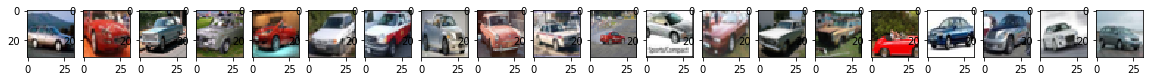

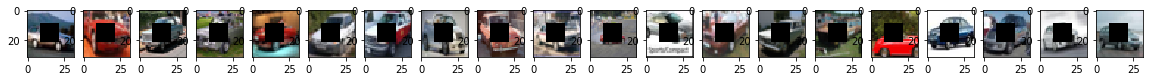

(5000, 32, 32, 1)
(1000, 32, 32, 1)


In [2]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 1]
x_test = x_test[y_test.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

(x_tra,y_tra),(x_te,y_te) = keras.datasets.cifar10.load_data()
x_tra = x_tra[y_tra.flatten() == 1]
x_te = x_te[y_te.flatten() == 1]

# Normalize the pixels to 0 and 1 range
x_tra = x_tra.astype('float32') / 255.
x_te = x_te.astype('float32') / 255.

# Modfied training and testing imgs
x_train,x_train_patches = Img_incomp(x_train,x_tra)
x_test,x_test_patches = Img_incomp(x_test,x_te)
x_train_patches = np.array(x_train_patches)
x_test_patches = np.array(x_test_patches)

# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train,20,10)
plt.show()

# Incomplete part matrices
cond_train = np.ones((x_train.shape[0],32,32,1))
cond_test = np.ones((x_test.shape[0],32,32,1))
cond_train,_ = Img_incomp(cond_train,cond_train)
cond_test,_ = Img_incomp(cond_test,cond_test)
print (cond_train.shape)
print (cond_test.shape)

In [0]:
def full_csampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size,h_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def full_cvae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.binary_crossentropy(x, decode_z), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + full_cvae_log_var - K.square(full_cvae_mu) - K.exp(full_cvae_log_var), axis=-1)
    return xent_loss + kl_loss

In [9]:
# Construct the CVAE model
full_X = layers.Input(batch_shape=(batch_size,height,width,channels))
full_cond = layers.Input(batch_shape=(batch_size,height,width,1))
full_cvae_Input = layers.concatenate([full_X,full_cond], axis=-1)
full_cvae_l1 = layers.Conv2D(32,(4,4),activation='relu',padding='same')(full_cvae_Input)
full_cvae_l1 = layers.MaxPooling2D((2,2))(full_cvae_l1)
full_cvae_l2 = layers.Conv2D(64,(4,4),activation='relu',padding='same')(full_cvae_l1)
full_cvae_l2 = layers.MaxPooling2D((2,2))(full_cvae_l2)
full_cvae_l3 = layers.Conv2D(128,(4,4),activation='relu',padding='same')(full_cvae_l2)
full_cvae_l3 = layers.MaxPooling2D((2,2))(full_cvae_l3)
full_flat_layer = layers.Flatten()(full_cvae_l3)
full_cvae_mu = layers.Dense(h_dim,activation='relu')(full_flat_layer)
full_cvae_log_var = layers.Dense(h_dim,activation='relu')(full_flat_layer)

# Imputed latent values
full_cvae_z = layers.Lambda(full_csampling, output_shape=(h_dim,))([full_cvae_mu, full_cvae_log_var])
full_cond2 = layers.Flatten()(full_cond)
full_cvae_z_cond = layers.concatenate([full_cvae_z,full_cond2], axis=-1)
full_cvae_z_cond = layers.Reshape((4,4,128))(full_cvae_z_cond)

# CVAE decoder layers
full_cvae_decoder_111 = layers.Conv2DTranspose(128,(4,4),activation='relu',padding='same')
full_cvae_decoder_112 = layers.UpSampling2D((2,2))
full_cvae_decoder_l21 = layers.Conv2DTranspose(64,(4,4),activation='relu',padding='same')
full_cvae_decoder_122 = layers.UpSampling2D((2,2))
full_cvae_decoder_l31 = layers.Conv2DTranspose(32,(4,4),activation='relu',padding='same')
full_cvae_decoder_132 = layers.UpSampling2D((2,2))
full_cvae_decoder_l4 = layers.Conv2DTranspose(3,(4,4),activation='sigmoid',padding='same')

# CVAE model
full_cvae_decoder_1 = full_cvae_decoder_111(full_cvae_z_cond)
full_cvae_decoder_1 = full_cvae_decoder_112(full_cvae_decoder_1)
full_cvae_decoder_2 = full_cvae_decoder_l21(full_cvae_decoder_1)
full_cvae_decoder_2 = full_cvae_decoder_122(full_cvae_decoder_2)
full_cvae_decoder_3 = full_cvae_decoder_l31(full_cvae_decoder_2)
full_cvae_decoder_3 = full_cvae_decoder_132(full_cvae_decoder_3)
full_cvae_decoded = full_cvae_decoder_l4(full_cvae_decoder_3)
full_cvae = Model([full_X,full_cond],full_cvae_decoded)
full_cvae.summary()

# The decoder model
#cvae_z_input1 = layers.Input(batch_shape=(batch_size,height,width,channels))
#cvae_z_input2 = layers.Input(batch_shape=(batch_size,height,width,1))
#cx = layers.concatenate([cvae_z_input1,cvae_z_input2], axis=-1)
#cx = cvae_decoder_f1(cx)
#cx = cvae_decoder_out(cx)
#cvae_decoder = Model([cvae_z_input1,cvae_z_input2],cx)
#cvae_decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (50, 32, 32, 4)      0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (50, 32, 32, 32)     2080        concatenate_3[0][0]              
__________

In [12]:
full_cvae_opt = optimizers.Adam(0.0005,0.5)
full_cvae.compile(optimizer=full_cvae_opt, loss=full_cvae_loss)
full_cvae.fit([x_train,cond_train],x_tra,epochs=300,batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
5000/5000 [==============================] - 4s 861us/step - loss: 100688.1715
Epoch 2/300
5000/5000 [==============================] - 1s 280us/step - loss: 94111.1367
Epoch 3/300
5000/5000 [==============================] - 1s 278us/step - loss: 92516.4342
Epoch 4/300
5000/5000 [==============================] - 1s 278us/step - loss: 91921.9847
Epoch 5/300
5000/5000 [==============================] - 1s 277us/step - loss: 91199.3083
Epoch 6/300
5000/5000 [==============================] - 1s 273us/step - loss: 90941.3030
Epoch 7/300
5000/5000 [==============================] - 1s 279us/step - loss: 90522.8538
Epoch 8/300
5000/5000 [==============================] - 1s 282us/step - loss: 90252.0155
Epoch 9/300
5000/5000 [==============================] - 1s 281us/step - loss: 90091.8878
Epoch 10/300
5000/5000 [==============================] - 1s 281us/step - loss: 89869.8923
Epoch 11/300
5000/5000 [==========================

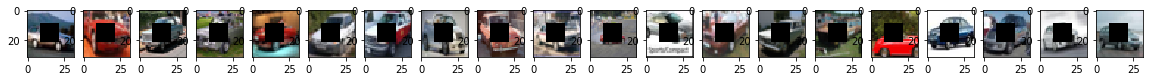

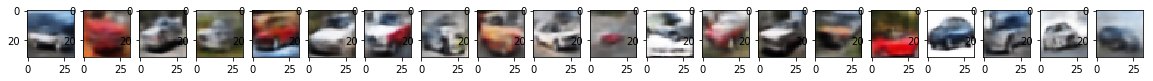

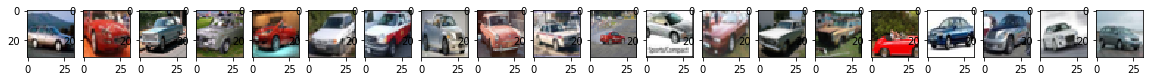

In [13]:
full_cvae_recons_train = full_cvae.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,x_train,20,10)
Plot_Img(20,full_cvae_recons_train,20,10)
Plot_Img(20,x_tra,20,10)
plt.show()

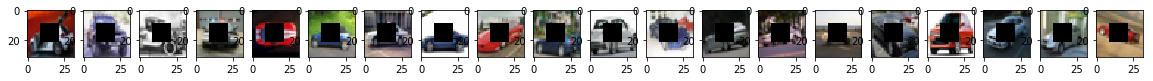

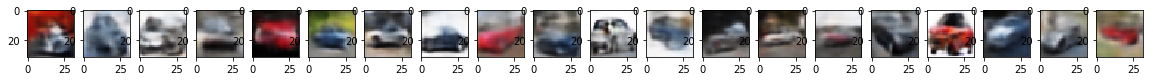

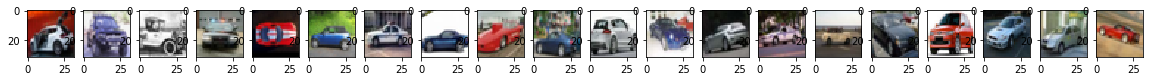

In [14]:
full_cvae_recons_test = full_cvae.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,x_test,20,10)
Plot_Img(20,full_cvae_recons_test,20,10)
Plot_Img(20,x_te,20,10)
plt.show()

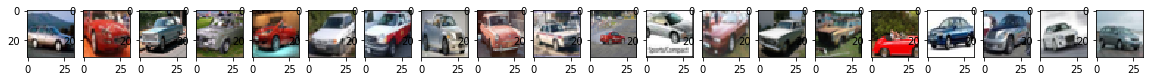

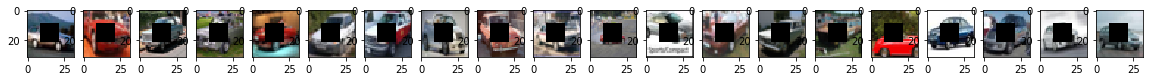

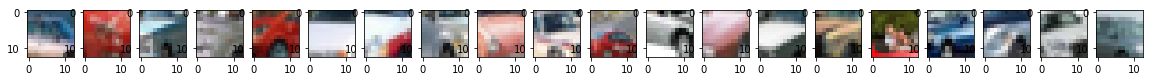

In [27]:
# Plot some examples
Plot_Img(20,x_tra,20,10)
Plot_Img(20,x_train,20,10)
Plot_Img(20,x_train_patches,20,10)
plt.show()

In [0]:
def csampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size,h_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

def cvae_loss(x, decode_z):
    x = K.flatten(x)
    decode_z = K.flatten(decode_z)
    xent_loss = K.sum(K.binary_crossentropy(x, decode_z), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + cvae_log_var - K.square(cvae_mu) - K.exp(cvae_log_var), axis=-1)
    return xent_loss + kl_loss

In [26]:
# Construct the CVAE model
X = layers.Input(batch_shape=(batch_size,height,width,channels))
cond = layers.Input(batch_shape=(batch_size,height,width,1))
cvae_Input = layers.concatenate([X,cond], axis=-1)
cvae_l1 = layers.Conv2D(32,(4,4),activation='relu',padding='same')(cvae_Input)
cvae_l1 = layers.MaxPooling2D((2,2))(cvae_l1)
cvae_l2 = layers.Conv2D(64,(4,4),activation='relu',padding='same')(cvae_l1)
cvae_l2 = layers.MaxPooling2D((2,2))(cvae_l2)
cvae_l3 = layers.Conv2D(128,(4,4),activation='relu',padding='same')(cvae_l2)
cvae_l3 = layers.MaxPooling2D((2,2))(cvae_l3)
flat_layer = layers.Flatten()(cvae_l3)
cvae_mu = layers.Dense(h_dim,activation='relu')(flat_layer)
cvae_log_var = layers.Dense(h_dim,activation='relu')(flat_layer)

# Imputed latent values
cvae_z = layers.Lambda(csampling, output_shape=(h_dim,))([cvae_mu, cvae_log_var])
cond2 = layers.Flatten()(cond)
cvae_z_cond = layers.concatenate([cvae_z,cond2], axis=-1)
cvae_z_cond = layers.Reshape((4,4,128))(cvae_z_cond)

# CVAE decoder layers
cvae_decoder_111 = layers.Conv2DTranspose(128,(4,4),activation='relu')
cvae_decoder_112 = layers.UpSampling2D((2,2))
cvae_decoder_l21 = layers.Conv2DTranspose(64,(4,4),activation='relu',strides=1,padding='same')
#cvae_decoder_122 = layers.UpSampling2D((2,2))
cvae_decoder_l31 = layers.Conv2DTranspose(32,(4,4),activation='relu',strides=1)
#cvae_decoder_132 = layers.UpSampling2D((2,2))
cvae_decoder_l4 = layers.Conv2DTranspose(3,(4,4),activation='sigmoid')

# CVAE model
cvae_decoder_1 = cvae_decoder_111(cvae_z_cond)
#cvae_decoder_1 = cvae_decoder_112(cvae_decoder_1)
cvae_decoder_2 = cvae_decoder_l21(cvae_decoder_1)
#cvae_decoder_2 = cvae_decoder_122(cvae_decoder_2)
cvae_decoder_3 = cvae_decoder_l31(cvae_decoder_2)
#cvae_decoder_3 = cvae_decoder_132(cvae_decoder_3)
cvae_decoded = cvae_decoder_l4(cvae_decoder_3)
cvae = Model([X,cond],cvae_decoded)
cvae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (50, 32, 32, 3)      0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (50, 32, 32, 1)      0                                            
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (50, 32, 32, 4)      0           input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (50, 32, 32, 32)     2080        concatenate_23[0][0]             
__________

In [32]:
cvae_opt = optimizers.Adam(0.0005,0.5)
cvae.compile(optimizer=cvae_opt, loss=cvae_loss)
cvae.fit([x_train,cond_train],x_train_patches,epochs=200,batch_size=batch_size)

Epoch 1/200
5000/5000 [==============================] - 2s 464us/step - loss: 14918.6398
Epoch 2/200
5000/5000 [==============================] - 1s 234us/step - loss: 14916.9813
Epoch 3/200
5000/5000 [==============================] - 1s 236us/step - loss: 14912.9362
Epoch 4/200
5000/5000 [==============================] - 1s 237us/step - loss: 14908.0250
Epoch 5/200
5000/5000 [==============================] - 1s 235us/step - loss: 14906.3080
Epoch 6/200
5000/5000 [==============================] - 1s 236us/step - loss: 14905.0111
Epoch 7/200
5000/5000 [==============================] - 1s 234us/step - loss: 14903.1776
Epoch 8/200
5000/5000 [==============================] - 1s 230us/step - loss: 14896.5378
Epoch 9/200
5000/5000 [==============================] - 1s 229us/step - loss: 14894.6909
Epoch 10/200
5000/5000 [==============================] - 1s 228us/step - loss: 14893.5645
Epoch 11/200
5000/5000 [==============================] - 1s 228us/step - loss: 14892.0986
Epoch 12

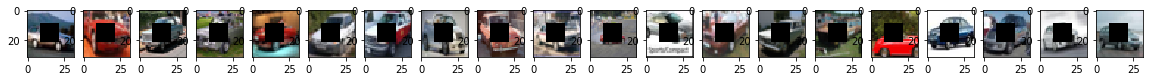

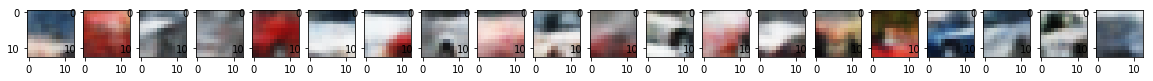

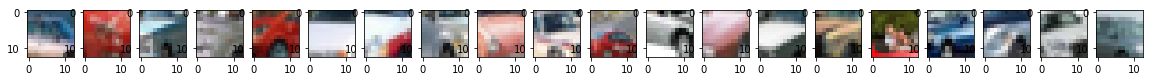

In [33]:
cvae_recons_train = cvae.predict([x_train,cond_train],batch_size=batch_size)
Plot_Img(20,x_train,20,10)
Plot_Img(20,cvae_recons_train,20,10)
Plot_Img(20,x_train_patches,20,10)
plt.show()

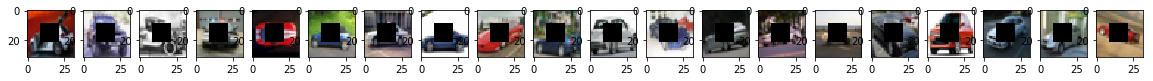

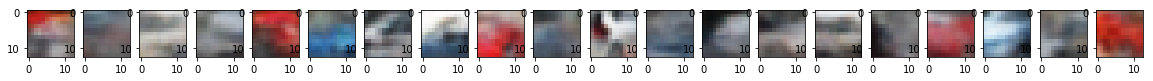

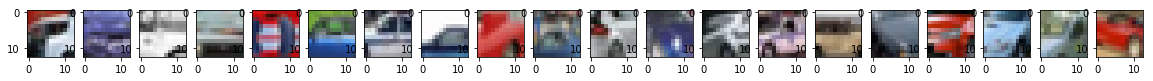

In [34]:
cvae_recons_test = cvae.predict([x_test,cond_test],batch_size=batch_size)
Plot_Img(20,x_test,20,10)
Plot_Img(20,cvae_recons_test,20,10)
Plot_Img(20,x_test_patches,20,10)
plt.show()